In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Parametros

In [2]:
START_DATE = "2015-01-30"
INITIAL_CAPITAL = 250_000
RISK_FREE_RATE = 0.02  # 2% anual

## Carga de datos cartera

In [3]:
portfolio_daily = pd.read_parquet("resources/portfolio_daily.parquet")
parquet = pd.read_parquet("resources/assignment_parquet.parquet")

## Descarga de datos SPY

In [4]:
spy = yf.download("SPY", start=START_DATE, end="2026-01-31", auto_adjust=True)
# eliminamos el nivel extra
spy.columns = spy.columns.droplevel(1)
spy.index.name = 'date'
spy = spy.reset_index()

[*********************100%***********************]  1 of 1 completed


## Retornos diarios de la estrategia

In [5]:
portfolio_daily['daily_return'] = portfolio_daily['portfolio_value'].pct_change()

## Retornos diarios del SPY como benchmark

In [6]:
spy['daily_return'] = spy['Close'].pct_change()

In [7]:
print(f"Días estrategia: {len(portfolio_daily)}")
print(f"Días SPY: {len(spy)}")
print(f"SPY precio inicial: ${spy['Close'].iloc[0]:,.2f}")
print(f"SPY precio final:   ${spy['Close'].iloc[-1]:,.2f}")
print(f"SPY retorno acumulado: {(spy['Close'].iloc[-1] / spy['Close'].iloc[0] - 1) * 100:.2f}%")

Días estrategia: 2766
Días SPY: 2767
SPY precio inicial: $165.62
SPY precio final:   $691.97
SPY retorno acumulado: 317.80%


## Métricas - Cálculos

In [8]:
n_years = (portfolio_daily['date'].iloc[-1] - portfolio_daily['date'].iloc[0]).days / 365.25

### CAGR

In [9]:
cagr_strategy = (portfolio_daily['portfolio_value'].iloc[-1] / INITIAL_CAPITAL) ** (1 / n_years) - 1
cagr_spy = (spy['Close'].iloc[-1] / spy['Close'].iloc[0]) ** (1 / n_years) - 1

### Volatilidad anualizada

In [10]:
vol_strategy = portfolio_daily['daily_return'].std() * np.sqrt(252)
vol_spy = spy['daily_return'].std() * np.sqrt(252)

### Sharpe

In [11]:
sharpe_strategy = (cagr_strategy - RISK_FREE_RATE) / vol_strategy
sharpe_spy = (cagr_spy - RISK_FREE_RATE) / vol_spy

### Sortino

In [12]:
neg_strategy = portfolio_daily['daily_return'][portfolio_daily['daily_return'] < 0].std() * np.sqrt(252)
neg_spy = spy['daily_return'][spy['daily_return'] < 0].std() * np.sqrt(252)
sortino_strategy = (cagr_strategy - RISK_FREE_RATE) / neg_strategy
sortino_spy = (cagr_spy - RISK_FREE_RATE) / neg_spy

### Max Drawdown

#### Cartera

In [13]:
rolling_max = portfolio_daily['portfolio_value'].cummax()
drawdown = (portfolio_daily['portfolio_value'] - rolling_max) / rolling_max
max_dd_strategy = drawdown.min()

#### SPY

In [14]:
rolling_max_spy = spy['Close'].cummax()
drawdown_spy = (spy['Close'] - rolling_max_spy) / rolling_max_spy
max_dd_spy = drawdown_spy.min()

## Métricas - Resultados

In [15]:
print(f"{'':20} {'Estrategia':>12} {'SPY':>12}")
print(f"{'─'*44}")
print(f"{'CAGR':20} {cagr_strategy:>11.2%} {cagr_spy:>11.2%}")
print(f"{'Volatilidad':20} {vol_strategy:>11.2%} {vol_spy:>11.2%}")
print(f"{'Sharpe':20} {sharpe_strategy:>11.2f} {sharpe_spy:>11.2f}")
print(f"{'Sortino':20} {sortino_strategy:>11.2f} {sortino_spy:>11.2f}")
print(f"{'Max Drawdown':20} {max_dd_strategy:>11.2%} {max_dd_spy:>11.2%}")

                       Estrategia          SPY
────────────────────────────────────────────
CAGR                      17.82%      13.88%
Volatilidad               27.24%      17.75%
Sharpe                      0.58        0.67
Sortino                     0.73        0.81
Max Drawdown             -39.08%     -33.72%


## Beta y Alpha

In [16]:
merged = portfolio_daily[['date', 'daily_return']].merge(spy[['date', 'daily_return']], on='date', suffixes=('_strategy', '_spy'))
merged = merged.dropna()

cov = np.cov(merged['daily_return_strategy'], merged['daily_return_spy'])
beta = cov[0, 1] / cov[1, 1]
alpha = cagr_strategy - (RISK_FREE_RATE + beta * (cagr_spy - RISK_FREE_RATE))

print(f"{'Beta':20} {beta:>11.2f}")
print(f"{'Alpha':20} {alpha:>11.2%}")

Beta                        1.13
Alpha                      2.38%


In [17]:
metrics = {
    'CAGR':           [f'{cagr_strategy:.2%}',    f'{cagr_spy:.2%}'],
    'Volatilidad':    [f'{vol_strategy:.2%}',      f'{vol_spy:.2%}'],
    'Sharpe':         [f'{sharpe_strategy:.2f}',   f'{sharpe_spy:.2f}'],
    'Sortino':        [f'{sortino_strategy:.2f}',  f'{sortino_spy:.2f}'],
    'Max Drawdown':   [f'{max_dd_strategy:.2%}',   f'{max_dd_spy:.2%}'],
    'Beta':           [f'{beta:.2f}',              f'1.00'],
    'Alpha':          [f'{alpha:.2%}',             f'0.00%'],
}

tabla = pd.DataFrame(metrics, index=['Estrategia', 'SPY']).T
print(tabla.to_string())

             Estrategia      SPY
CAGR             17.82%   13.88%
Volatilidad      27.24%   17.75%
Sharpe             0.58     0.67
Sortino            0.73     0.81
Max Drawdown    -39.08%  -33.72%
Beta               1.13     1.00
Alpha             2.38%    0.00%


## Métricas - Gráficos

### Evolución Rentabilidad Acumulada

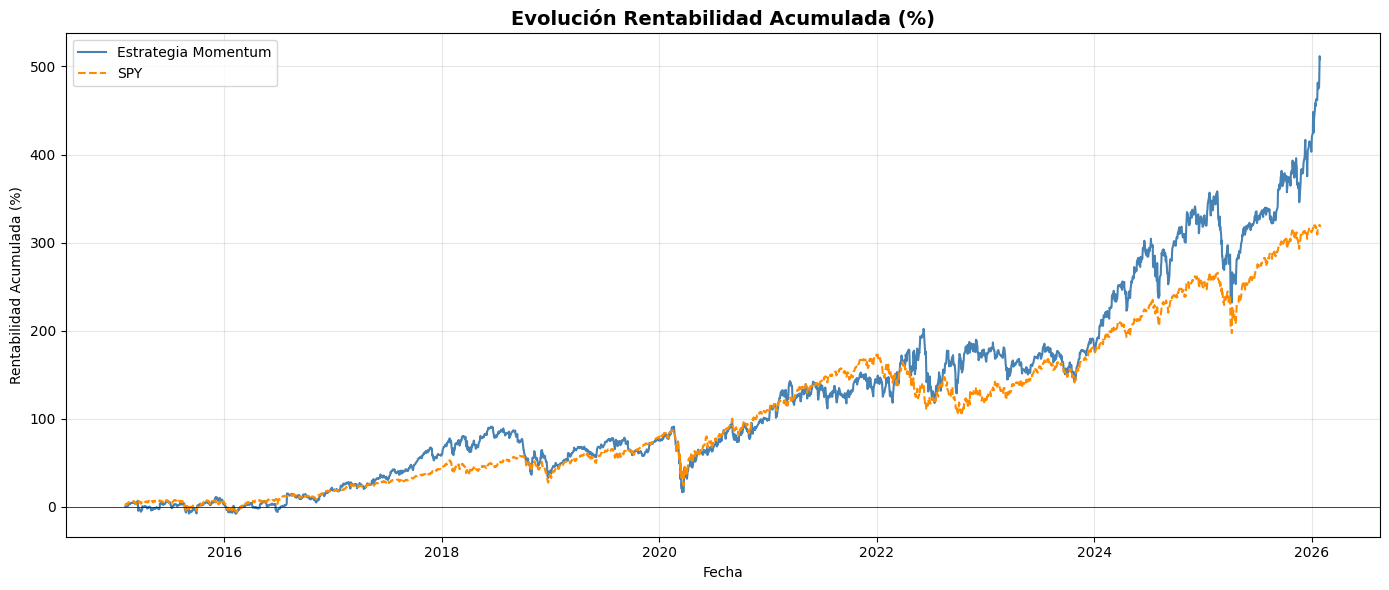

In [18]:
portfolio_daily['cum_return'] = (1 + portfolio_daily['daily_return']).cumprod() - 1
spy['cum_return'] = (1 + spy['daily_return']).cumprod() - 1

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(portfolio_daily['date'], portfolio_daily['cum_return'] * 100,
        label='Estrategia Momentum', color='steelblue', linewidth=1.5)
ax.plot(spy['date'], spy['cum_return'] * 100,
        label='SPY', color='darkorange', linewidth=1.5, linestyle='--')
ax.set_title('Evolución Rentabilidad Acumulada (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Rentabilidad Acumulada (%)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

### Histograma de Retornos Mensuales

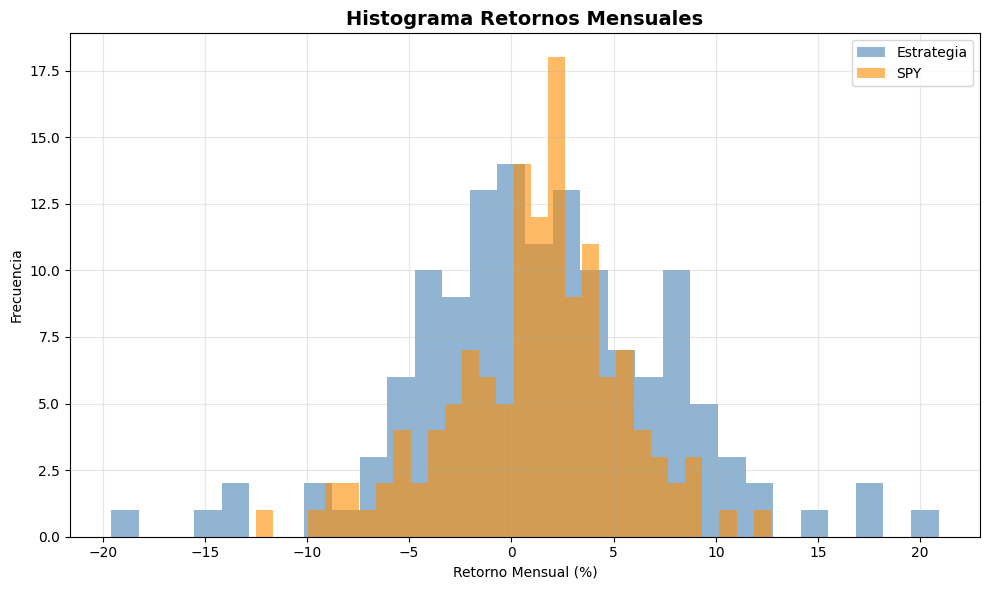

In [19]:
portfolio_daily['month'] = portfolio_daily['date'].dt.to_period('M')
spy['month'] = spy['date'].dt.to_period('M')

monthly_strategy = portfolio_daily.groupby('month')['daily_return'].apply(lambda x: (1+x).prod()-1)
monthly_spy = spy.groupby('month')['daily_return'].apply(lambda x: (1+x).prod()-1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(monthly_strategy * 100, bins=30, alpha=0.6, color='steelblue', label='Estrategia')
ax.hist(monthly_spy * 100, bins=30, alpha=0.6, color='darkorange', label='SPY')
ax.set_title('Histograma Retornos Mensuales', fontsize=14, fontweight='bold')
ax.set_xlabel('Retorno Mensual (%)')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/grafico2_histograma.png', dpi=150, bbox_inches='tight')
plt.show()

### Scatter retornos trimestrales

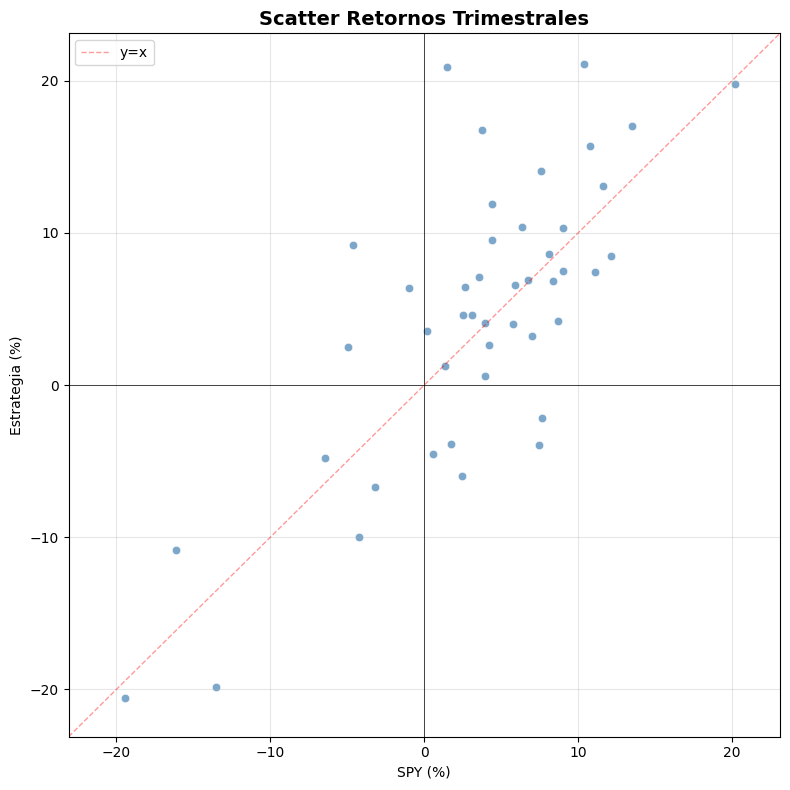

In [20]:
portfolio_daily['quarter'] = portfolio_daily['date'].dt.to_period('Q')
spy['quarter'] = spy['date'].dt.to_period('Q')

quarterly_strategy = portfolio_daily.groupby('quarter')['daily_return'].apply(lambda x: (1+x).prod()-1)
quarterly_spy = spy.groupby('quarter')['daily_return'].apply(lambda x: (1+x).prod()-1)
common_q = quarterly_strategy.index.intersection(quarterly_spy.index)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(quarterly_spy[common_q] * 100, quarterly_strategy[common_q] * 100,
           color='steelblue', alpha=0.7, edgecolors='white', linewidth=0.5)
lim = max(abs(quarterly_spy[common_q]).max(), abs(quarterly_strategy[common_q]).max()) * 100 + 2
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.4, linewidth=1, label='y=x')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('Scatter Retornos Trimestrales', fontsize=14, fontweight='bold')
ax.set_xlabel('SPY (%)')
ax.set_ylabel('Estrategia (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/grafico3_scatter_trimestral.png', dpi=150, bbox_inches='tight')
plt.show()

### Scatter retornos anuales

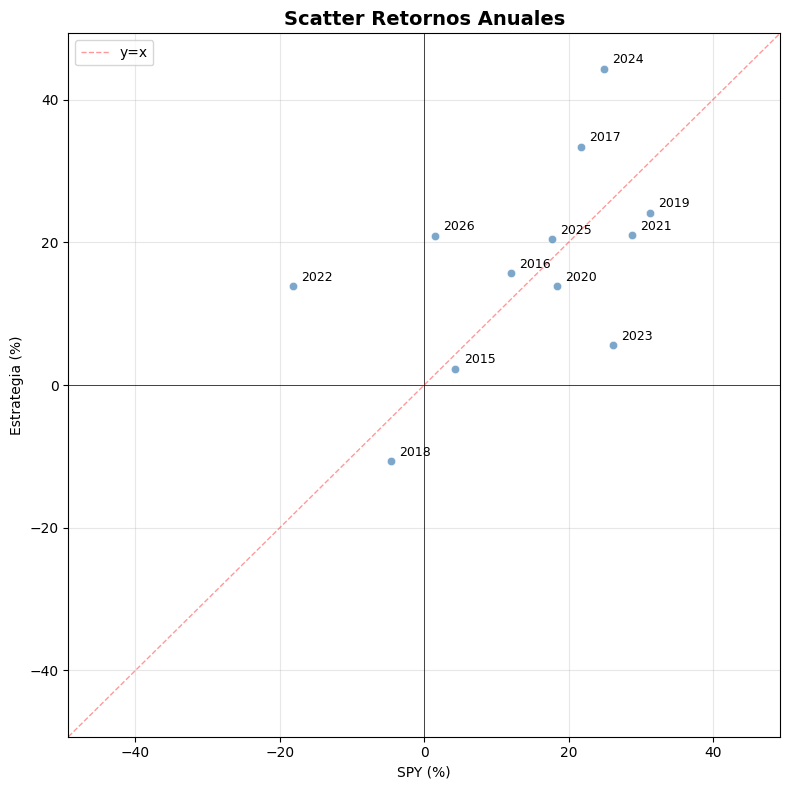

In [21]:
portfolio_daily['year'] = portfolio_daily['date'].dt.year
spy['year'] = spy['date'].dt.year

annual_strategy = portfolio_daily.groupby('year')['daily_return'].apply(lambda x: (1+x).prod()-1)
annual_spy = spy.groupby('year')['daily_return'].apply(lambda x: (1+x).prod()-1)
common_y = annual_strategy.index.intersection(annual_spy.index)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(annual_spy[common_y] * 100, annual_strategy[common_y] * 100,
           color='steelblue', alpha=0.7, edgecolors='white', linewidth=0.5, zorder=3)

for year in common_y:
    ax.annotate(str(year),
                (annual_spy[year] * 100, annual_strategy[year] * 100),
                textcoords='offset points', xytext=(6, 4), fontsize=9)

lim = max(abs(annual_spy[common_y]).max(), abs(annual_strategy[common_y]).max()) * 100 + 5
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.plot([-lim, lim], [-lim, lim], 'r--', alpha=0.4, linewidth=1, label='y=x')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_title('Scatter Retornos Anuales', fontsize=14, fontweight='bold')
ax.set_xlabel('SPY (%)')
ax.set_ylabel('Estrategia (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/grafico4_scatter_anual.png', dpi=150, bbox_inches='tight')
plt.show()

## Monte Carlo

### Carga de datos

In [22]:
universe = pd.read_parquet("resources/universe.parquet")
monthly_closes = pd.read_parquet("resources/monthly_closes.parquet")
rebalancing_dates = pd.read_parquet("resources/rebalancing_dates.parquet")

In [23]:
monthly_closes['period'] = monthly_closes['date'].dt.to_period('M')

# Para cada fecha de rebalanceo cogemos los retornos del mes t-1
monkey_returns = []

for _, row in rebalancing_dates.iterrows():
    rebal_date = row['date']
    t = rebal_date.to_period('M')

    # Todos los activos en el S&P 500 ese mes, sin filtro de 13 meses
    sp500_that_month = parquet[
        (parquet['date'] == rebal_date) &
        (parquet['in_sp500'] == 1)
    ]['symbol'].tolist()

    mask = (
        (monthly_closes['period'] == t) &
        (monthly_closes['symbol'].isin(sp500_that_month))
    )

    rets = monthly_closes[mask]['log_return'].dropna().values
    monkey_returns.append(rets)

print(f"Periodos: {len(monkey_returns)}")
print(f"Media activos por periodo: {np.mean([len(r) for r in monkey_returns]):.0f}")
print(f"Retorno mensual medio universo: {np.mean([r.mean() for r in monkey_returns]):.4f}")

Periodos: 133
Media activos por periodo: 504
Retorno mensual medio universo: 0.0058


In [26]:
N_MONOS = 25_000_000
N_ASSETS = 20
COMMISSION_MONKEY = 0.0046  # 0.23% x2
BATCH_SIZE = 1_000_000
n_batches = N_MONOS // BATCH_SIZE
n_periods =  len(rebalancing_dates)
n_years = n_periods / 12

max_assets = max(len(r) for r in monkey_returns)
monkey_matrix = np.full((n_periods, max_assets), np.nan, dtype=np.float32)
for t, r in enumerate(monkey_returns):
    monkey_matrix[t, :len(r)] = r


cagr_monos = np.zeros(N_MONOS)

np.random.seed(42)

In [27]:
start_time = pd.Timestamp.now()

for i in range(n_batches):

    batch_monthly = np.zeros((BATCH_SIZE, n_periods), dtype=np.float32)

    for t in range(n_periods):

        valid = ~np.isnan(monkey_matrix[t])
        n_valid = valid.sum()

        idx = np.random.randint(0, n_valid, size=(BATCH_SIZE, N_ASSETS))

        sampled = monkey_matrix[t, valid][idx]

        rets_simple = np.exp(sampled.mean(axis=1)) - 1
        rets_net = np.log((1 + rets_simple) * (1 - COMMISSION_MONKEY))  # restar comisión correctamente
        batch_monthly[:, t] = rets_net

    # aplicar costes
    batch_monthly -= COMMISSION_MONKEY

    # retorno total en log → pasar a simple
    total_return = np.exp(batch_monthly.sum(axis=1))

    cagr_monos[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = total_return**(1/n_years) - 1

    print(f"Batch {i+1}/{n_batches} completado")

elapsed = (pd.Timestamp.now() - start_time).total_seconds()
print(f"⏱️ Tiempo total: {elapsed:.1f} segundos ({elapsed/3600:.2f} horas)")

Batch 1/25 completado
Batch 2/25 completado
Batch 3/25 completado
Batch 4/25 completado
Batch 5/25 completado
Batch 6/25 completado
Batch 7/25 completado
Batch 8/25 completado
Batch 9/25 completado
Batch 10/25 completado
Batch 11/25 completado
Batch 12/25 completado
Batch 13/25 completado
Batch 14/25 completado
Batch 15/25 completado
Batch 16/25 completado
Batch 17/25 completado
Batch 18/25 completado
Batch 19/25 completado
Batch 20/25 completado
Batch 21/25 completado
Batch 22/25 completado
Batch 23/25 completado
Batch 24/25 completado
Batch 25/25 completado
⏱️ Tiempo total: 273.0 segundos (0.08 horas)


Resultados Monte Carlo (25,000,000 simulaciones)
─────────────────────────────────────────────
CAGR medio monos:     -4.03%
CAGR mediano monos:   -4.04%
CAGR std monos:       1.69%
CAGR mín monos:       -12.88%
CAGR máx monos:       5.87%
─────────────────────────────────────────────
Nuestro CAGR:         17.82%
Percentil:            100.0%
Superamos a:          100.0% de los monos


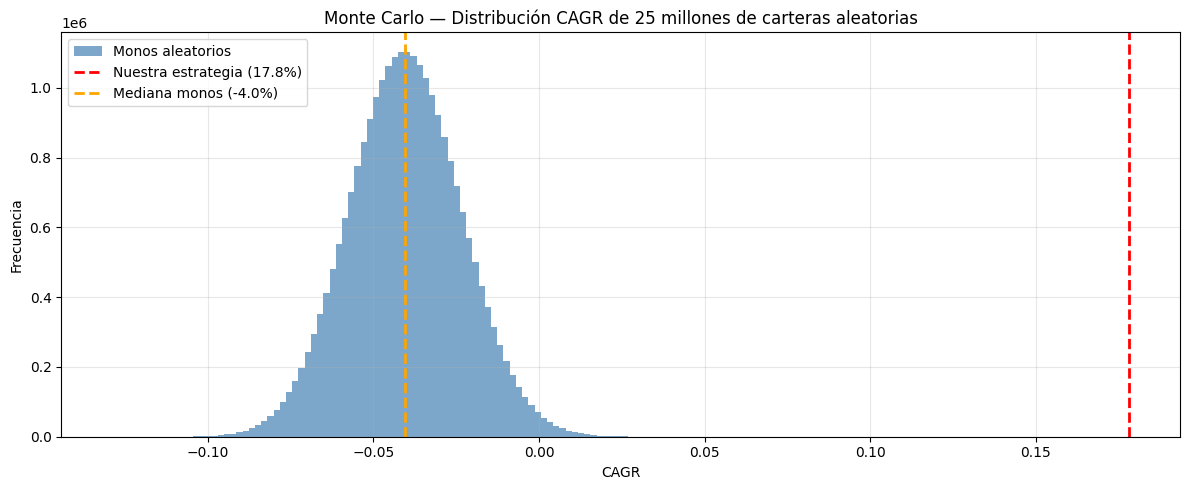

In [29]:
# ------------------------------------------------------------
# RESULTADOS MONTE CARLO
# ------------------------------------------------------------

our_cagr = cagr_strategy

print(f"Resultados Monte Carlo ({N_MONOS:,} simulaciones)")
print(f"{'─'*45}")
print(f"CAGR medio monos:     {cagr_monos.mean():.2%}")
print(f"CAGR mediano monos:   {np.median(cagr_monos):.2%}")
print(f"CAGR std monos:       {cagr_monos.std():.2%}")
print(f"CAGR mín monos:       {cagr_monos.min():.2%}")
print(f"CAGR máx monos:       {cagr_monos.max():.2%}")
print(f"{'─'*45}")
print(f"Nuestro CAGR:         {our_cagr:.2%}")
percentile = (cagr_monos < our_cagr).mean() * 100
print(f"Percentil:            {percentile:.1f}%")
print(f"Superamos a:          {percentile:.1f}% de los monos")

# Gráfico
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(cagr_monos, bins=100, color='steelblue', alpha=0.7, label='Monos aleatorios')
ax.axvline(our_cagr, color='red', linewidth=2, linestyle='--', label=f'Nuestra estrategia ({our_cagr:.1%})')
ax.axvline(np.median(cagr_monos), color='orange', linewidth=2, linestyle='--', label=f'Mediana monos ({np.median(cagr_monos):.1%})')
ax.set_title('Monte Carlo — Distribución CAGR de 25 millones de carteras aleatorias')
ax.set_xlabel('CAGR')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('resources/grafico5_montecarlo.png', dpi=150, bbox_inches='tight')
plt.show()

In [125]:
print("Media monos:", cagr_monos.mean())
print("Max monos:", cagr_monos.max())
print("Min monos:", cagr_monos.min())
print("Tu CAGR:", our_cagr)

Media monos: 0.01428433272824049
Max monos: 0.11889839172363281
Min monos: -0.07928663492202759
Tu CAGR: 0.17815983
